# Program with minimal amplitude based on (kappa1, gamma1), (kappa2, gamma2), kappa3

In [1]:
import numpy as np

import matplotlib.pyplot as plt

import scipy.signal

import time

In [2]:
# for two-soliton solution only; not relevant for three-soliton solution
def find_x0_t0(soliton1, soliton2):
    kappa1, gamma1square = soliton1
    kappa2, gamma2square = soliton2
    
    Mat = np.zeros((2, 3))
    Mat[0][0] = 1 
    Mat[0][1] = -4*kappa1**2
    Mat[0][2] = 1/(2*kappa1) * np.log(gamma1square / (2*kappa1)) - 1/(2*kappa1)*np.log((kappa1+kappa2)/(kappa1-kappa2))
    
    Mat[1][0] = 1 
    Mat[1][1] = -4*kappa2**2
    Mat[1][2] = 1/(2*kappa2) * np.log(gamma2square / (2*kappa2)) - 1/(2*kappa2)*np.log((kappa1+kappa2)/(kappa1-kappa2))
    
    x0, t0 = np.linalg.solve(Mat[:, :2], Mat[:, 2])
    
    return (x0, t0)

In [3]:
def make_plot(xarr, uarr, t, show=1, linewidth=1):
    plt.plot(xarr, uarr, linewidth=linewidth)    
    plt.ylim((-1, 3))
    umax = np.max(uarr)
    xmax = xarr[np.argmax(uarr)]
    
    peaks = scipy.signal.find_peaks(uarr, threshold=1e-6)
    negpeaks = scipy.signal.find_peaks(-uarr, threshold=1e-6)
    
    Npeaks = peaks[0].size
    Nnegpeaks = negpeaks[0].size
        
    plt.text(xarr[0], 2.4, "t={:.3}".format(t))
    plt.text(xarr[0], 2.6, "max={:.6}, xmax={:.6}".format(umax, xmax))
    plt.text(xarr[0], 2.8, "Num_peaks={}, Num_neg_peaks={}".format(Npeaks, Nnegpeaks))

    for i in range(Npeaks):
        index = peaks[0][i]
        plt.text(6, 2.4 + 0.2 * (Npeaks - i - 1), "Peak {}: x={:.3}, u={:.3}".format(i + 1, xarr[index], uarr[index]))

    for i in range(Nnegpeaks):
        index = negpeaks[0][i]
        plt.text(1, 1.6 + 0.2 * (Npeaks - i - 1), "Neg peak {}: x={:.3}, u={:.3}".format(i+1, xarr[index], uarr[index]))
    if (1 == show):
        plt.show()

In [4]:
#kappa1 = 1; gamma1square = 3;
#kappa2 = 0.75; gamma2square = 4;


def find_inf_sup_three_solitons(sol1, sol2, sol3, plot=0):
    start = time.time()

    kappa1, gamma1square = sol1
    kappa2, gamma2square = sol2
    kappa3, gamma3square = sol3
    
    x12, t12 = find_x0_t0(sol1, sol2)
    x13, t13 = find_x0_t0(sol1, sol3)
    x23, t23 = find_x0_t0(sol2, sol3)
    
    pairwise_times = np.array([t12, t13, t23])
    pairwise_pos = np.array([x12, x13, x23])
    #print("pairwise_times: {}".format(pairwise_times))
    #print("pairwise_pos: {}".format(pairwise_times))
    
    tleft = np.min(pairwise_times)
    tright = np.max(pairwise_times)
    Nt = 100
    tarr = np.linspace(tleft - (tright - tleft)/2, tright + (tright - tleft)/2, Nt)
    
    #xleft = np.min(pairwise_pos)
    #xright = np.max(pairwise_pos)
    Nx = 1000
    #xarr = np.linspace(xleft - (xright - xleft)/2, xright + (xright - xleft)/2, Nx)
    xarr = np.linspace(-30, 30, Nx)
    
    
    Mat = np.zeros((tarr.shape[0], xarr.shape[0], 3, 4), dtype=float)

    theta1 = -2 * kappa1 * xarr.reshape(1, -1) + 8 * kappa1**3 * tarr.reshape(-1, 1)
    theta2 = -2 * kappa2 * xarr.reshape(1, -1) + 8 * kappa2**3 * tarr.reshape(-1, 1)
    theta3 = -2 * kappa3 * xarr.reshape(1, -1) + 8 * kappa3**3 * tarr.reshape(-1, 1)

    exp1 = np.where(theta1 <= 0, np.exp(theta1), np.exp(-theta1))
    exp2 = np.where(theta2 <= 0, np.exp(theta2), np.exp(-theta2))
    exp3 = np.where(theta3 <= 0, np.exp(theta3), np.exp(-theta3))

    Mat[:, :, 0, 0] = np.where(theta1 <= 0, 1 + exp1 * gamma1square / (2*kappa1), exp1 + gamma1square / (2 * kappa1))
    Mat[:, :, 0, 1] = np.where(theta1 <= 0, exp1 * gamma1square / (kappa1 + kappa2), gamma1square / (kappa1 + kappa2))
    Mat[:, :, 0, 2] = np.where(theta1 <= 0, gamma1square * exp1 / (kappa1 + kappa3), gamma1square / (kappa1 + kappa3))
    Mat[:, :, 0, 3] = np.where(theta1 <= 0, gamma1square * exp1, gamma1square)

    Mat[:, :, 1, 0] = np.where(theta2 <= 0, exp2 * gamma2square / (kappa1 + kappa2), gamma2square / (kappa1 + kappa2))
    Mat[:, :, 1, 1] = np.where(theta2 <= 0, 1 + exp2 * gamma2square / (2 * kappa2), exp2 + gamma2square / (2 * kappa2))
    Mat[:, :, 1, 2] = np.where(theta2 <= 0, gamma2square * exp2 / (kappa2 + kappa3), gamma2square / (kappa2 + kappa3))
    Mat[:, :, 1, 3] = np.where(theta2 <= 0, gamma2square * exp2, gamma2square)

    Mat[:, :, 2, 0] = np.where(theta3 <= 0, exp3 * gamma3square / (kappa1 + kappa3), gamma3square / (kappa1 + kappa3))
    Mat[:, :, 2, 1] = np.where(theta3 <= 0, exp3 * gamma3square / (kappa2 + kappa3), gamma3square / (kappa2 + kappa3))
    Mat[:, :, 2, 2] = np.where(theta3 <= 0, 1 + gamma3square * exp3 / (2 * kappa3), exp3 + gamma3square / (2 * kappa3))
    Mat[:, :, 2, 3] = np.where(theta3 <= 0, gamma3square * exp3, gamma3square)

    alphas = np.linalg.solve(Mat[:, :, :, :3], Mat[:, :, :, 3].reshape(Mat.shape[:-1] + (1,)))
    u = 4 * (alphas[:, :, 0] * kappa1 + alphas[:, :, 1] * kappa2 + alphas[:, :, 2] * kappa3)\
        - 2 * (alphas[:, :, 0] + alphas[:, :, 1] + alphas[:, :, 2])**2

    u = u.squeeze()
    
    uinfsup = np.min(np.max(u, axis=1))
    
    time_index = np.argmin(np.max(u, axis=1))
    
    if (1 == plot):
        plt.plot(xarr, u[time_index, :])
        for (t, uarr) in zip(tarr, u):
            plt.plot(xarr, uarr)
        make_plot(xarr, u[time_index, :], tarr[time_index])
    
    end = time.time()
    #print(end - start)
    return (xarr, u, uinfsup, time_index, tarr[time_index])

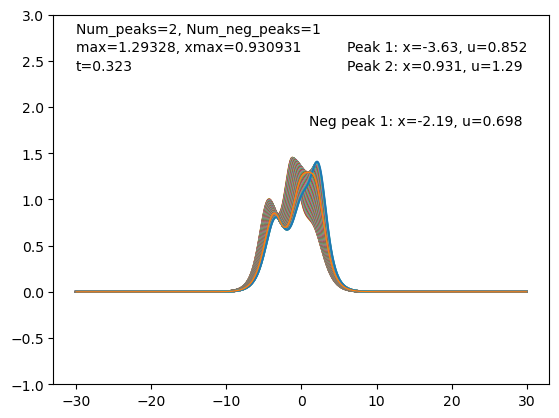

(array([-30.        , -29.93993994, -29.87987988, -29.81981982,
        -29.75975976, -29.6996997 , -29.63963964, -29.57957958,
        -29.51951952, -29.45945946, -29.3993994 , -29.33933934,
        -29.27927928, -29.21921922, -29.15915916, -29.0990991 ,
        -29.03903904, -28.97897898, -28.91891892, -28.85885886,
        -28.7987988 , -28.73873874, -28.67867868, -28.61861862,
        -28.55855856, -28.4984985 , -28.43843844, -28.37837838,
        -28.31831832, -28.25825826, -28.1981982 , -28.13813814,
        -28.07807808, -28.01801802, -27.95795796, -27.8978979 ,
        -27.83783784, -27.77777778, -27.71771772, -27.65765766,
        -27.5975976 , -27.53753754, -27.47747748, -27.41741742,
        -27.35735736, -27.2972973 , -27.23723724, -27.17717718,
        -27.11711712, -27.05705706, -26.996997  , -26.93693694,
        -26.87687688, -26.81681682, -26.75675676, -26.6966967 ,
        -26.63663664, -26.57657658, -26.51651652, -26.45645646,
        -26.3963964 , -26.33633634, -26.

In [5]:
kappa1 = 1; gamma1square = 3;
kappa2 = 0.75; gamma2square = 4;
kappa3 = 0.5; gamma3square = 5


u = find_inf_sup_three_solitons((kappa1, gamma1square), (kappa2, gamma2square), (kappa3, gamma3square), plot=1)
u

In [6]:
def find_gamma3(sol1, sol2, kappa3):
    '''determines gamma3, given two solitons and the kappa3 of the third soliton'''
    
    kappa1, gamma1square = sol1
    kappa2, gamma2square = sol2
    
    gamma3squarearr = np.linspace(2.5, 2.7, 100)
    #gamma3squarearr = np.exp(lngamma3squarearr)
    print(gamma3squarearr)
    
    uinfsuparr = []
    wholeu_arr = []
    time_index_arr = []
    time_arr = []
    
    counter = 0
    for gamma3square in gamma3squarearr:
        print("counter: {}\ngamma3square:{}".format(counter, gamma3square))
        counter += 1
        xarr, u, uinfsup, time_index, time = find_inf_sup_three_solitons(sol1, sol2, (kappa3, gamma3square), 0)
        
        wholeu_arr.append(u)
        uinfsuparr.append(uinfsup)
        time_index_arr.append(time_index)
        time_arr.append(time)
        
        make_plot(xarr, u[time_index, :], time, show=0)
    
    index = np.argmin(uinfsuparr)
    gamma3squarearr[index]
    
    plt.plot(xarr, wholeu_arr[index][time_index_arr[index], :], )
    make_plot(xarr, wholeu_arr[index][time_index_arr[index], :], time_arr[index])
    
    plt.show()
    return (np.min(np.array(uinfsuparr)), gamma3squarearr[index])

[2.5        2.5020202  2.5040404  2.50606061 2.50808081 2.51010101
 2.51212121 2.51414141 2.51616162 2.51818182 2.52020202 2.52222222
 2.52424242 2.52626263 2.52828283 2.53030303 2.53232323 2.53434343
 2.53636364 2.53838384 2.54040404 2.54242424 2.54444444 2.54646465
 2.54848485 2.55050505 2.55252525 2.55454545 2.55656566 2.55858586
 2.56060606 2.56262626 2.56464646 2.56666667 2.56868687 2.57070707
 2.57272727 2.57474747 2.57676768 2.57878788 2.58080808 2.58282828
 2.58484848 2.58686869 2.58888889 2.59090909 2.59292929 2.59494949
 2.5969697  2.5989899  2.6010101  2.6030303  2.60505051 2.60707071
 2.60909091 2.61111111 2.61313131 2.61515152 2.61717172 2.61919192
 2.62121212 2.62323232 2.62525253 2.62727273 2.62929293 2.63131313
 2.63333333 2.63535354 2.63737374 2.63939394 2.64141414 2.64343434
 2.64545455 2.64747475 2.64949495 2.65151515 2.65353535 2.65555556
 2.65757576 2.65959596 2.66161616 2.66363636 2.66565657 2.66767677
 2.66969697 2.67171717 2.67373737 2.67575758 2.67777778 2.6797

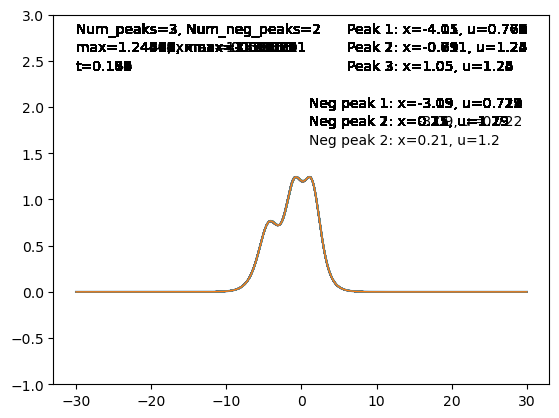

(np.float64(1.2437623453141091), np.float64(2.621212121212121))

In [7]:
find_gamma3((kappa1, gamma1square), (kappa2, gamma2square), kappa3)

In [ ]:
(1.2438878193069094, 2.7676767676767677)

In [ ]:
(1.2437835911334982, 2.6222222222222222)

In [ ]:
(1.2437623453141091, 2.621212121212121)

# Symmetric 3-soliton solution

In [15]:
import numpy as np

import matplotlib.pyplot as plt

import scipy.signal

import time

In [16]:
def find_x0_t0_gamma3square(sol1, sol2, kappa3):
    kappa1, gamma1square = sol1
    kappa2, gamma2square = sol2
    
    # find x0, t0 from first two equations
    Mat = np.array([[1, -4*kappa1**2], [1, -4*kappa2**2]], dtype=float)
    vect = np.zeros(2, dtype=float)
    vect[0] = 1/(2*kappa1) * np.log(gamma1square / (2*kappa1)) \
            - 1/(2*kappa1) * np.log((kappa1+kappa2)/(kappa1-kappa2) * (kappa1+kappa3)/(kappa1-kappa3))
    vect[1] = 1/(2*kappa2) * np.log(gamma2square / (2*kappa2)) \
            - 1/(2*kappa2) * np.log((kappa1+kappa2)/(kappa1-kappa2) * (kappa2+kappa3)/(kappa2-kappa3))
    x0, t0 = np.linalg.solve(Mat, vect.reshape(2, 1)).squeeze()
    
    # find gamma3square from the third equation
    gamma3square = 2*kappa3 * np.exp(2*kappa3*(x0 - 4 * kappa3**2 * t0) \
                      + np.log((kappa1+kappa3)/(kappa1-kappa3) * (kappa2+kappa3)/(kappa2-kappa3)))
    #print("gamma3square is : {}".format(gamma3square))
    return (x0, t0, gamma3square)
    

In [17]:
def get_xarr_tarr_symmetric(sol1, sol2, kappa3):
    xinter, tinter, gamma3square = find_x0_t0_gamma3square((kappa1, gamma1square), (kappa2, gamma2square), kappa3)
    print("xinter: {}, tinter: {}, gamma3square: {}".format(xinter, tinter, gamma3square))

    tarr = np.linspace(tinter, tinter + 5/kappa1, 100)
    Nx = 10000
    xarr = np.linspace(xinter -30, xinter + 30, Nx)
    
    return (xarr, tarr)

In [18]:
# Program with vectorized

def get_u(sol1, sol2, sol3, xt_arr):
    start = time.time()
    
    kappa1, gamma1square = sol1
    kappa2, gamma2square = sol2
    kappa3, gamma3square = sol3
    
    xarr, tarr = xt_arr
    
    Mat = np.zeros((tarr.shape[0], xarr.shape[0], 3, 4), dtype=float)

    theta1 = -2 * kappa1 * xarr.reshape(1, -1) + 8 * kappa1**3 * tarr.reshape(-1, 1)
    theta2 = -2 * kappa2 * xarr.reshape(1, -1) + 8 * kappa2**3 * tarr.reshape(-1, 1)
    theta3 = -2 * kappa3 * xarr.reshape(1, -1) + 8 * kappa3**3 * tarr.reshape(-1, 1)

    exp1 = np.where(theta1 <= 0, np.exp(theta1), np.exp(-theta1))
    exp2 = np.where(theta2 <= 0, np.exp(theta2), np.exp(-theta2))
    exp3 = np.where(theta3 <= 0, np.exp(theta3), np.exp(-theta3))

    Mat[:, :, 0, 0] = np.where(theta1 <= 0, 1 + exp1 * gamma1square / (2*kappa1), exp1 + gamma1square / (2 * kappa1))
    Mat[:, :, 0, 1] = np.where(theta1 <= 0, exp1 * gamma1square / (kappa1 + kappa2), gamma1square / (kappa1 + kappa2))
    Mat[:, :, 0, 2] = np.where(theta1 <= 0, gamma1square * exp1 / (kappa1 + kappa3), gamma1square / (kappa1 + kappa3))
    Mat[:, :, 0, 3] = np.where(theta1 <= 0, gamma1square * exp1, gamma1square)

    Mat[:, :, 1, 0] = np.where(theta2 <= 0, exp2 * gamma2square / (kappa1 + kappa2), gamma2square / (kappa1 + kappa2))
    Mat[:, :, 1, 1] = np.where(theta2 <= 0, 1 + exp2 * gamma2square / (2 * kappa2), exp2 + gamma2square / (2 * kappa2))
    Mat[:, :, 1, 2] = np.where(theta2 <= 0, gamma2square * exp2 / (kappa2 + kappa3), gamma2square / (kappa2 + kappa3))
    Mat[:, :, 1, 3] = np.where(theta2 <= 0, gamma2square * exp2, gamma2square)

    Mat[:, :, 2, 0] = np.where(theta3 <= 0, exp3 * gamma3square / (kappa1 + kappa3), gamma3square / (kappa1 + kappa3))
    Mat[:, :, 2, 1] = np.where(theta3 <= 0, exp3 * gamma3square / (kappa2 + kappa3), gamma3square / (kappa2 + kappa3))
    Mat[:, :, 2, 2] = np.where(theta3 <= 0, 1 + gamma3square * exp3 / (2 * kappa3), exp3 + gamma3square / (2 * kappa3))
    Mat[:, :, 2, 3] = np.where(theta3 <= 0, gamma3square * exp3, gamma3square)

    alphas = np.linalg.solve(Mat[:, :, :, :3], Mat[:, :, :, 3].reshape(Mat.shape[:-1] + (1,)))
    u = 4 * (alphas[:, :, 0] * kappa1 + alphas[:, :, 1] * kappa2 + alphas[:, :, 2] * kappa3)\
        - 2 * (alphas[:, :, 0] + alphas[:, :, 1] + alphas[:, :, 2])**2

    u = u.squeeze()

    end = time.time()
    print("program computing u took {} seconds".format(end - start))
    return (xarr, tarr, u)

In [88]:
kappa1 = 1; gamma1square = 3;
kappa2 = 0.55; gamma2square = 4;
kappa3 = 0.5;

x0, t0, gamma3square = find_x0_t0_gamma3square((kappa1, gamma1square), (kappa2, gamma2square), kappa3)

xarr, tarr = get_xarr_tarr_symmetric((kappa1, gamma1square), (kappa2, gamma2square), kappa3)

_, _, u = get_u((kappa1, gamma1square), \
      (kappa2, gamma2square), \
      (kappa3, gamma3square), \
      (xarr, tarr))

u

#x0, t0, gamma3square = find_x0_t0_gamma3square((kappa1, gamma1square), (kappa2, gamma2square), kappa3)
#print(x0, t0, gamma3square)

#find_inf_sup_three_solitons((kappa1, gamma1square), (kappa2, gamma2square), (kappa3, gamma3square), plot=1)



xinter: -3.4789340362322827, tinter: -0.6284947830944616, gamma3square: 3.6425918437593086
program computing u took 0.292755126953125 seconds


array([[1.42108547e-11, 1.42108547e-11, 1.42108547e-11, ...,
        1.27593187e-11, 1.26824916e-11, 1.26061274e-11],
       [1.26334498e-11, 1.26334498e-11, 1.26334498e-11, ...,
        1.34349313e-11, 1.33540280e-11, 1.32736122e-11],
       [1.15747412e-11, 1.15747412e-11, 1.15747412e-11, ...,
        1.41465609e-11, 1.40613636e-11, 1.39766797e-11],
       ...,
       [9.73443548e-13, 9.73443548e-13, 9.73443548e-13, ...,
        7.99512162e-08, 7.90099624e-08, 7.80798605e-08],
       [9.73443548e-13, 9.73443548e-13, 9.73443548e-13, ...,
        1.18801683e-07, 1.17397665e-07, 1.16010316e-07],
       [9.73443548e-13, 9.73443548e-13, 9.73443548e-13, ...,
        1.76940713e-07, 1.74843870e-07, 1.72771955e-07]])

In [89]:
def make_plot(xarr, uarr, t, show=1, linewidth=1):
    plt.plot(xarr, uarr, linewidth=linewidth)    
    plt.ylim((-1, 3))
    umax = np.max(uarr)
    xmax = xarr[np.argmax(uarr)]
    
    peaks = scipy.signal.find_peaks(uarr, threshold=1e-6)
    negpeaks = scipy.signal.find_peaks(-uarr, threshold=1e-6)
    
    Npeaks = peaks[0].size
    Nnegpeaks = negpeaks[0].size
        
    plt.text(xarr[0], 2.4, "t={:.3}".format(t))
    plt.text(xarr[0], 2.6, "max={:.6}, xmax={:.6}".format(umax, xmax))
    plt.text(xarr[0], 2.8, "Num_peaks={}, Num_neg_peaks={}".format(Npeaks, Nnegpeaks))

    for i in range(Npeaks):
        index = peaks[0][i]
        plt.text(6, 2.4 + 0.2 * (Npeaks - i - 1), "Peak {}: x={:.3}, u={:.3}".format(i + 1, xarr[index], uarr[index]))

    for i in range(Nnegpeaks):
        index = negpeaks[0][i]
        plt.text(1, 1.6 + 0.2 * (Npeaks - i - 1), "Neg peak {}: x={:.3}, u={:.3}".format(i+1, xarr[index], uarr[index]))
    if (1 == show):
        plt.show()

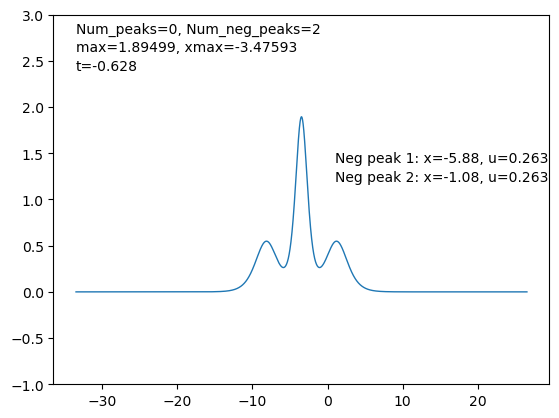

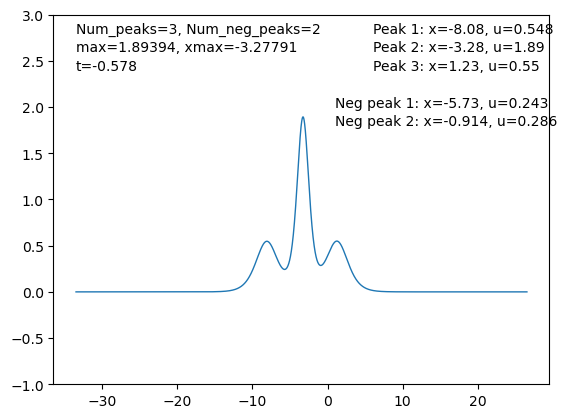

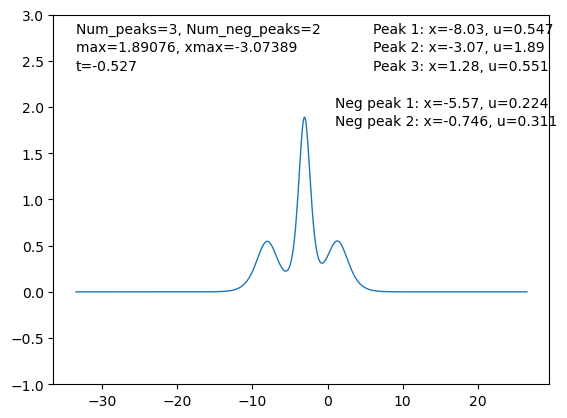

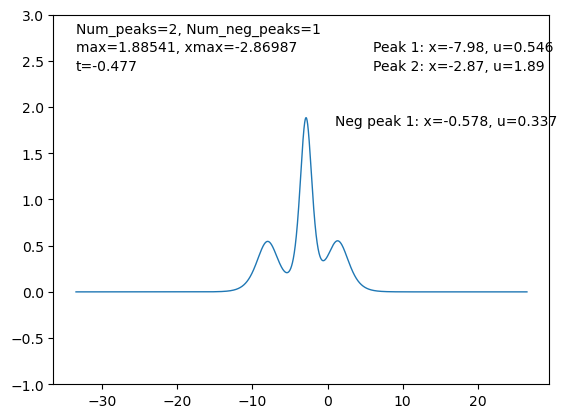

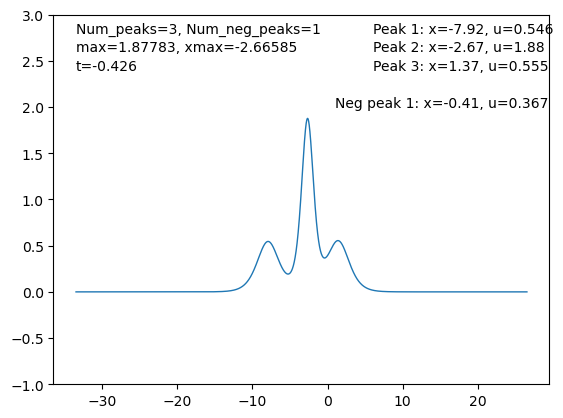

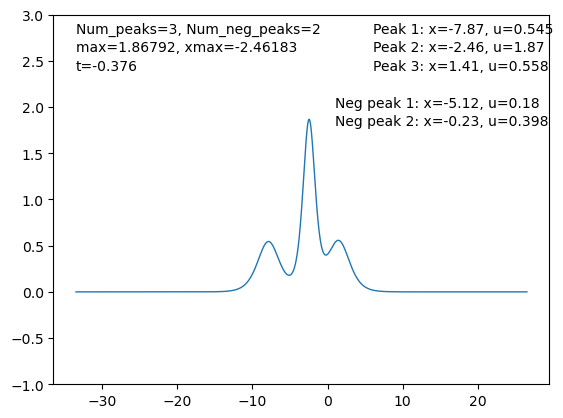

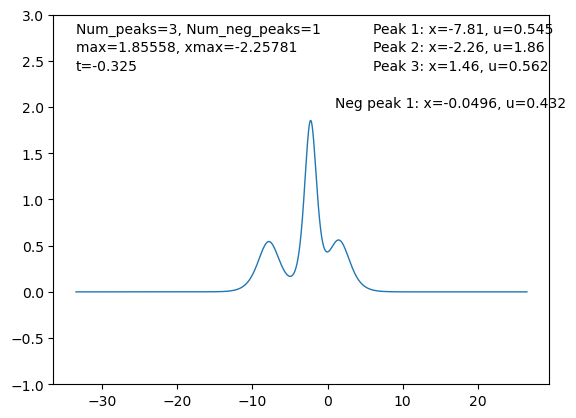

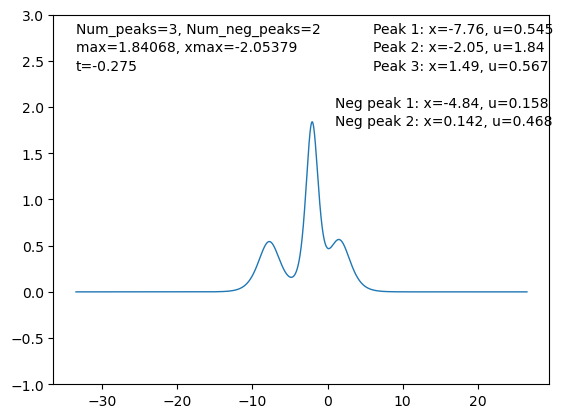

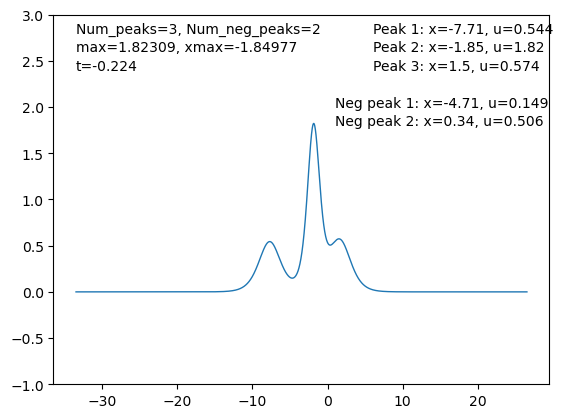

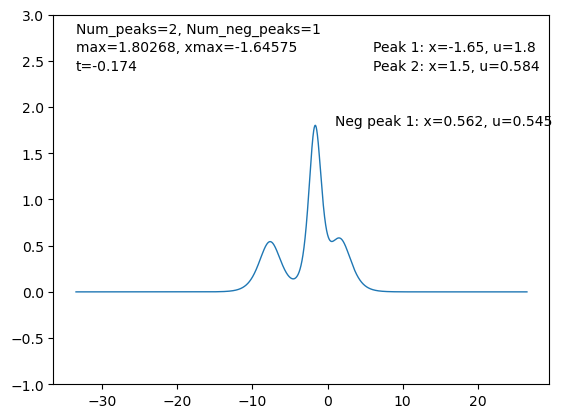

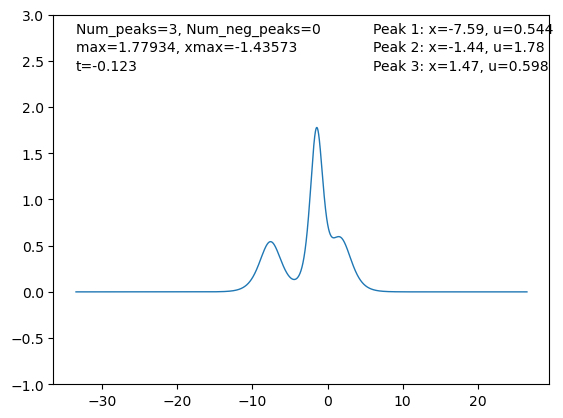

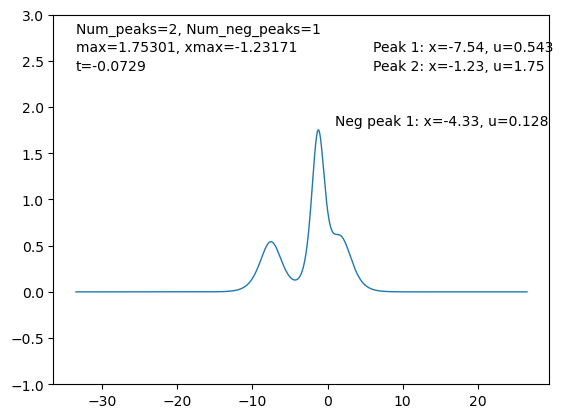

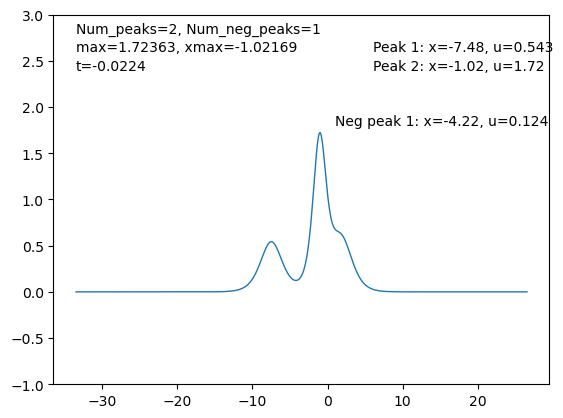

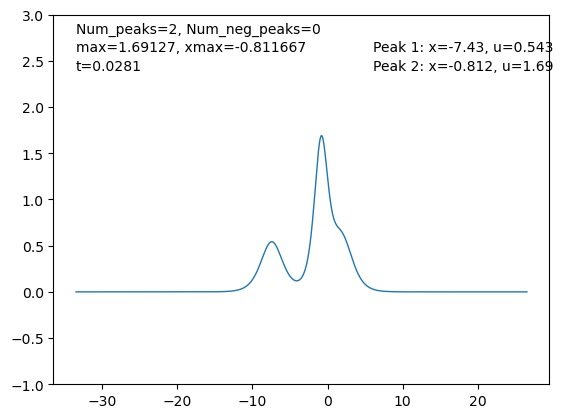

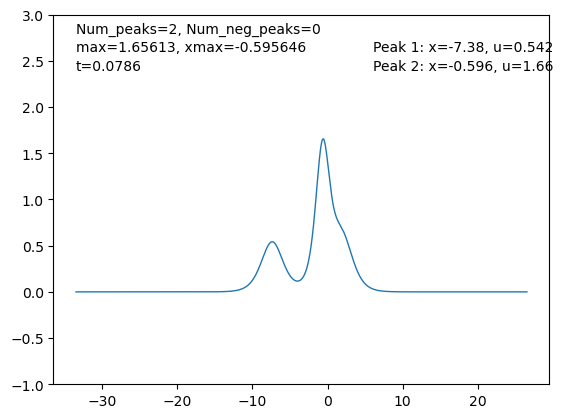

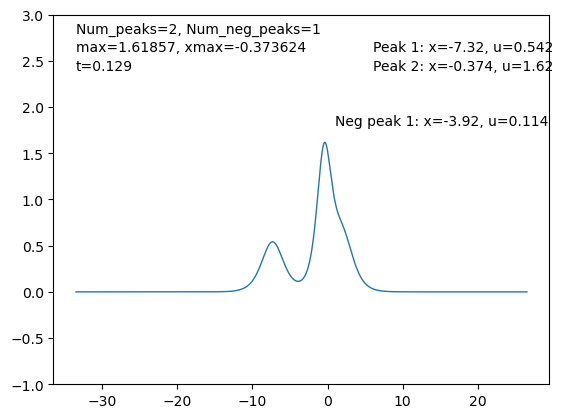

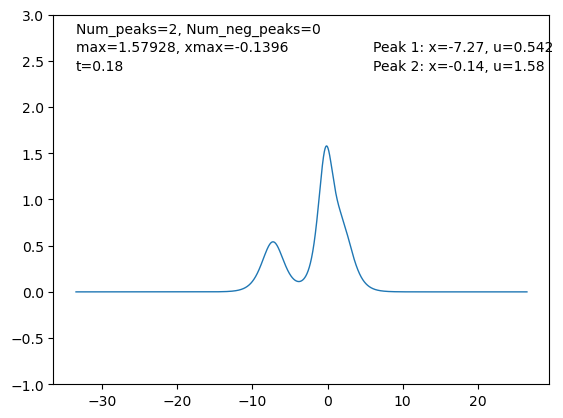

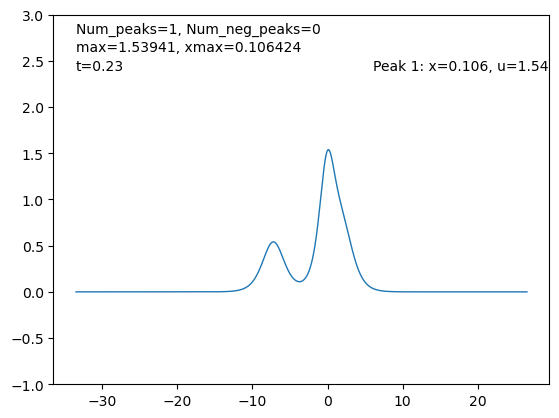

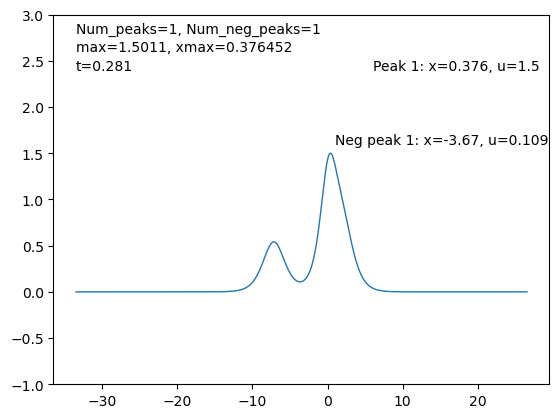

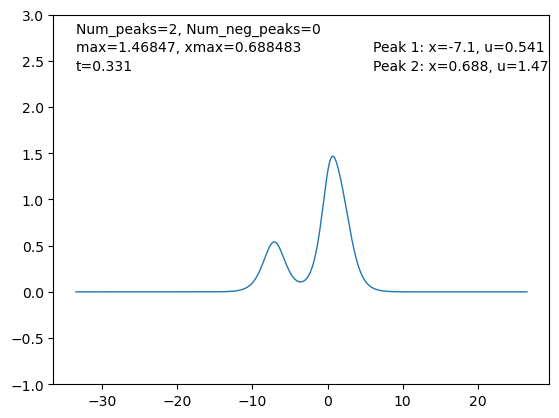

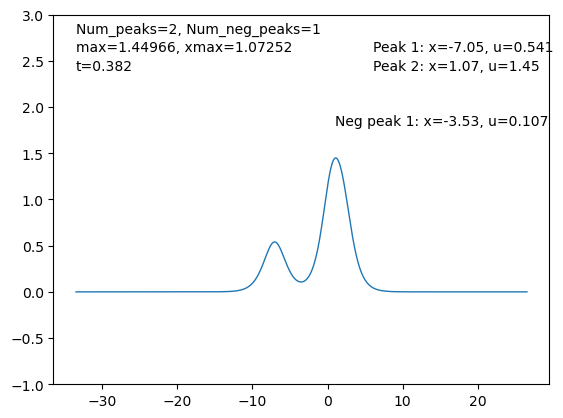

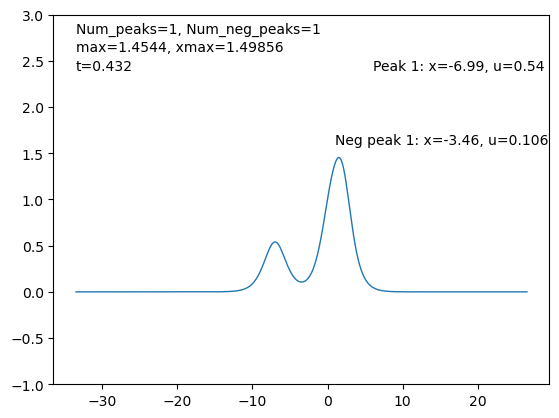

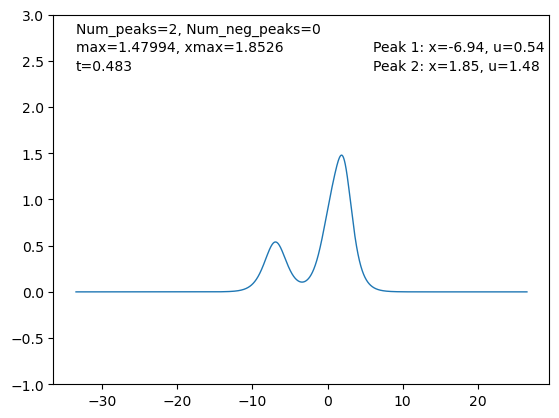

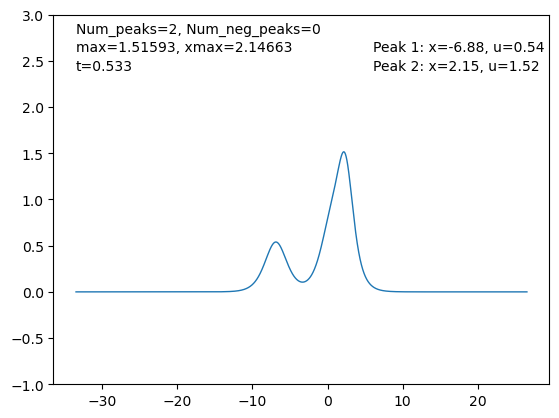

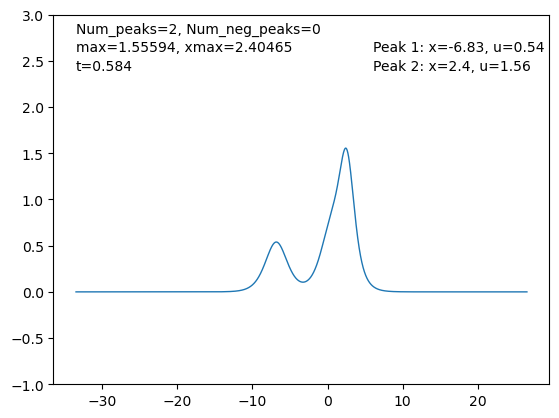

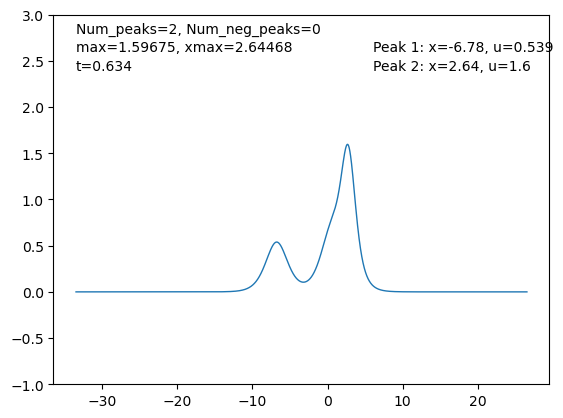

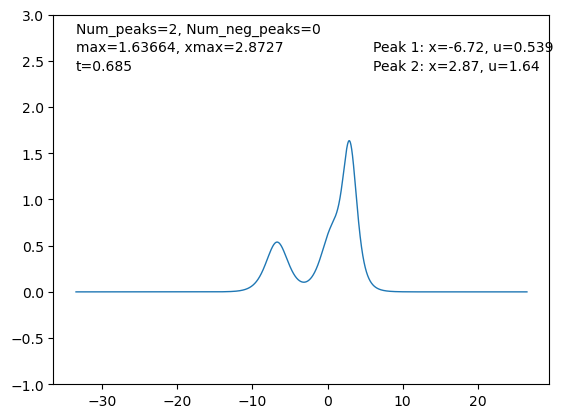

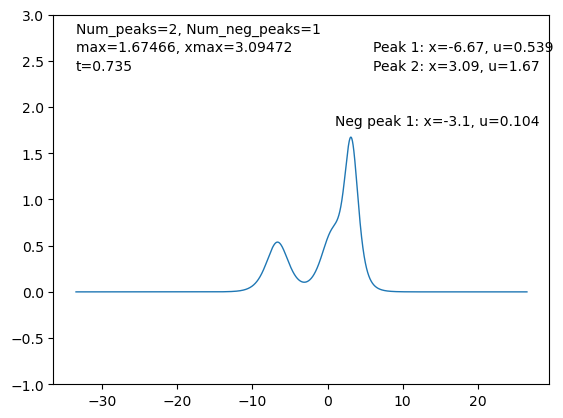

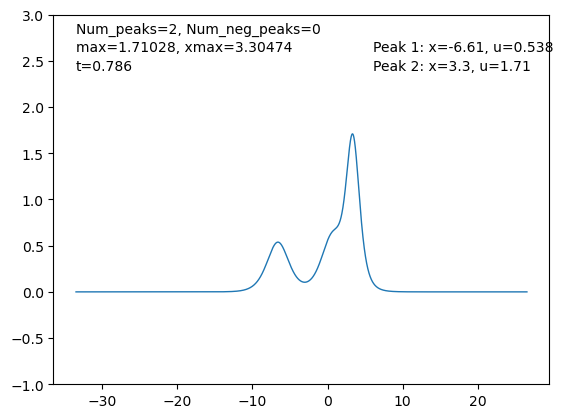

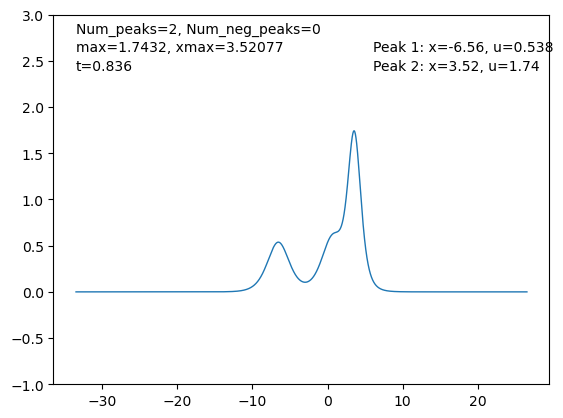

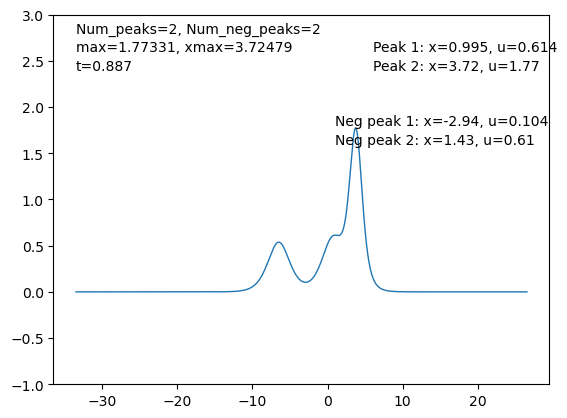

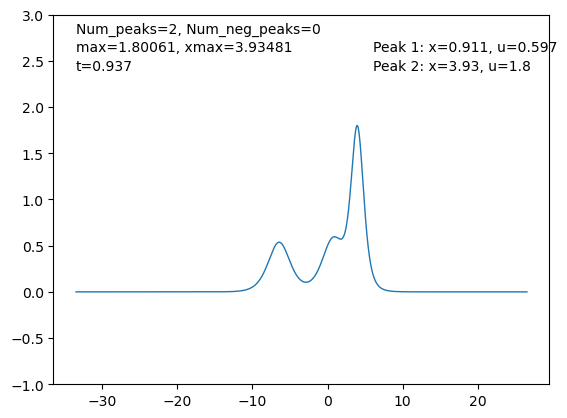

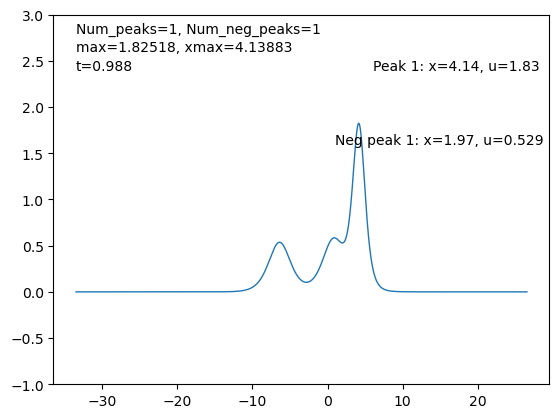

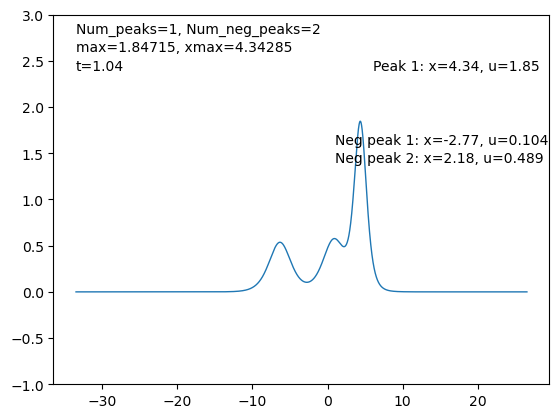

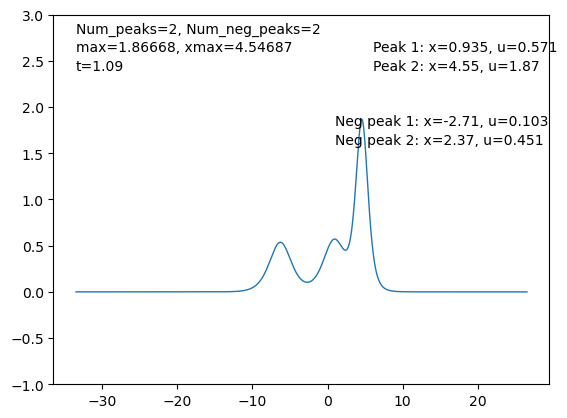

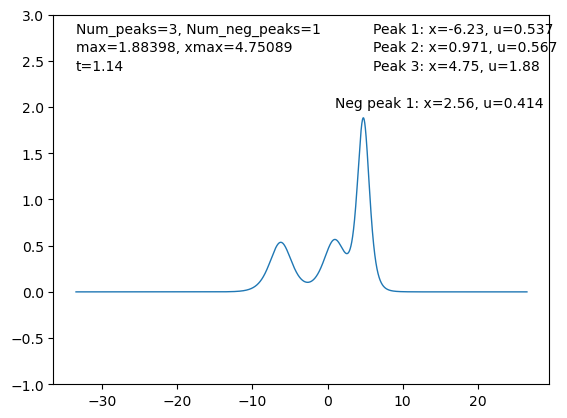

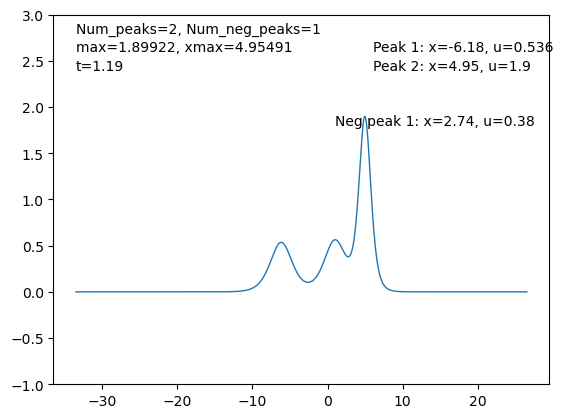

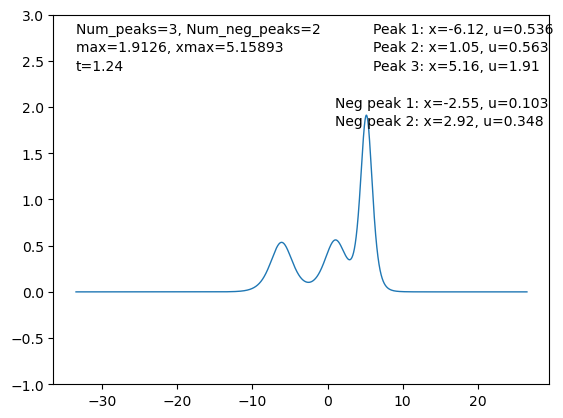

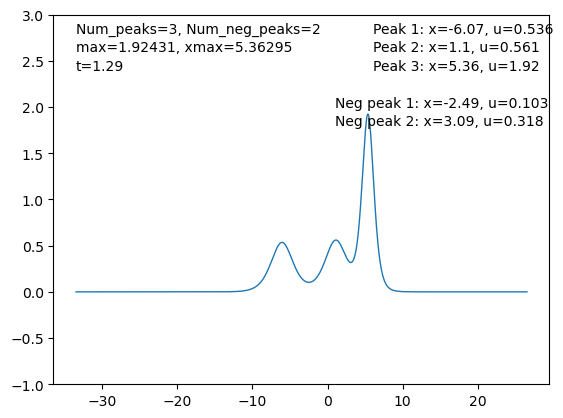

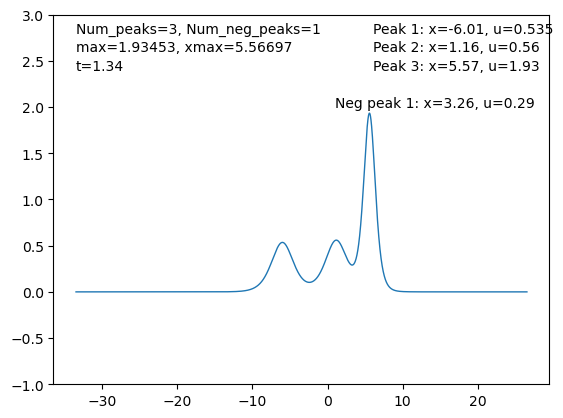

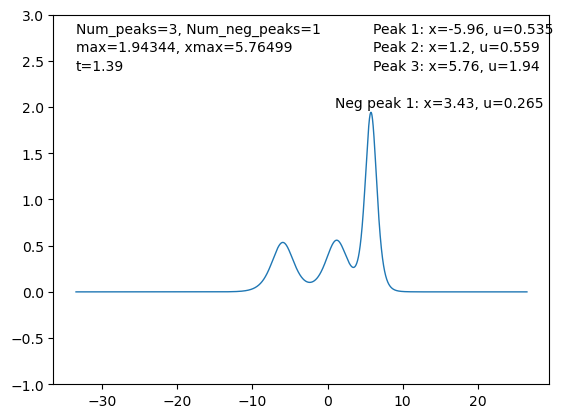

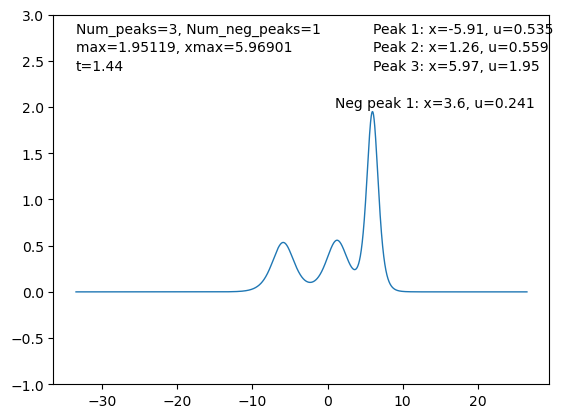

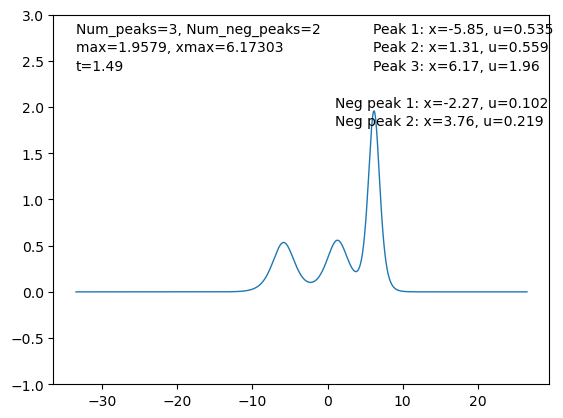

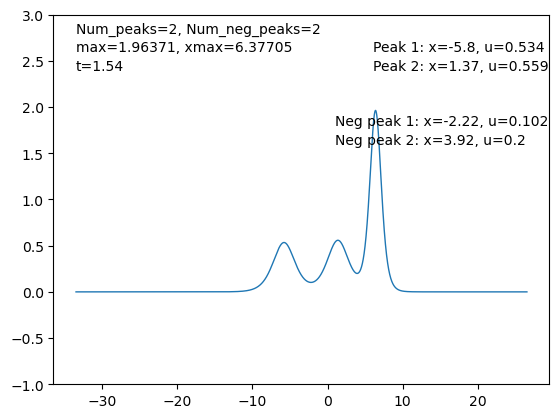

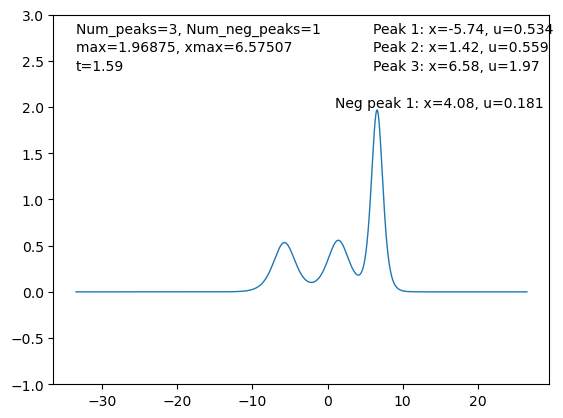

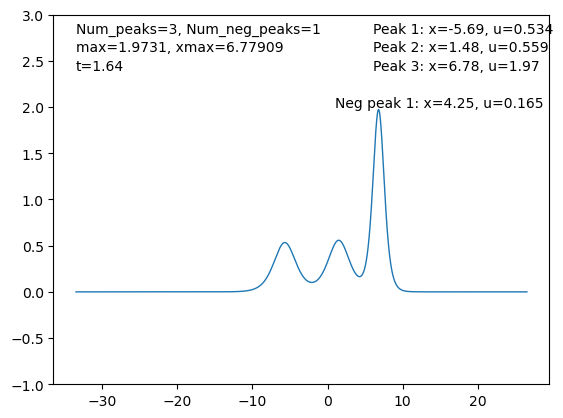

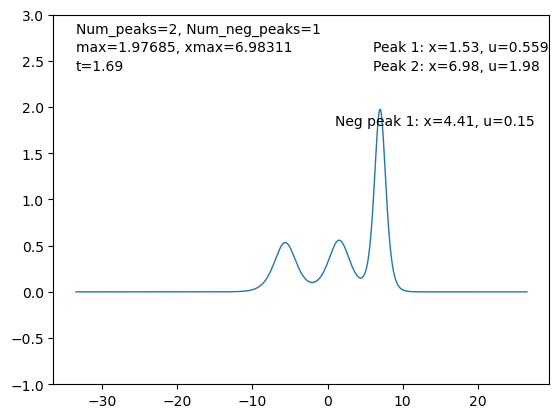

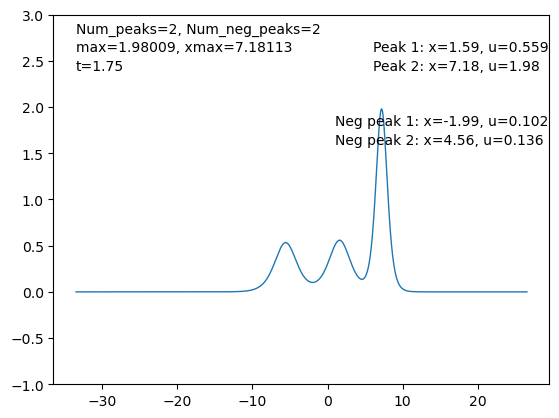

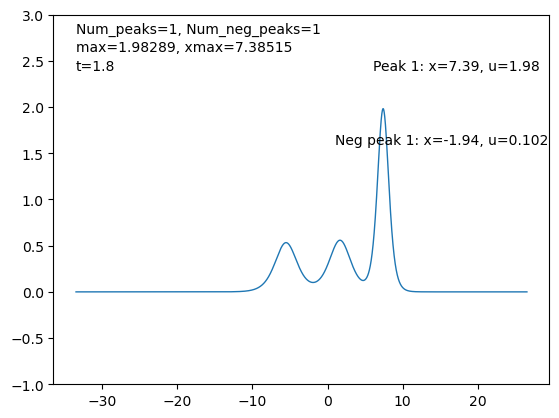

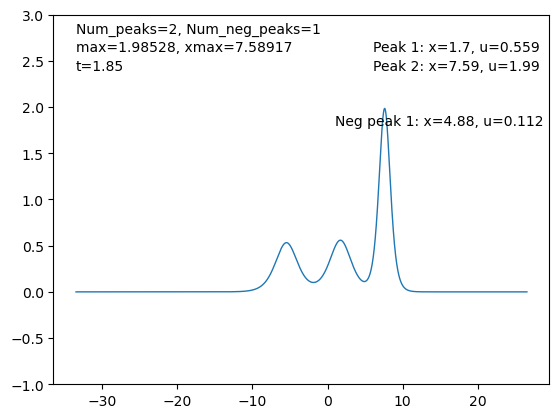

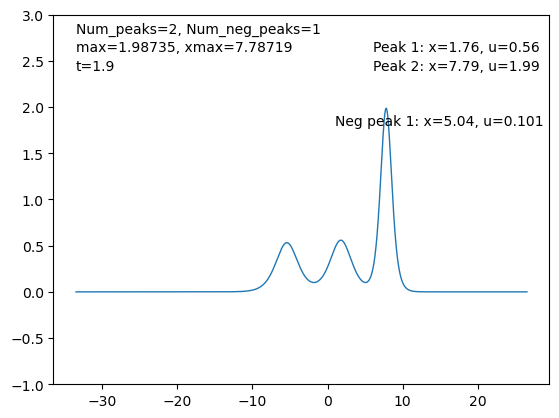

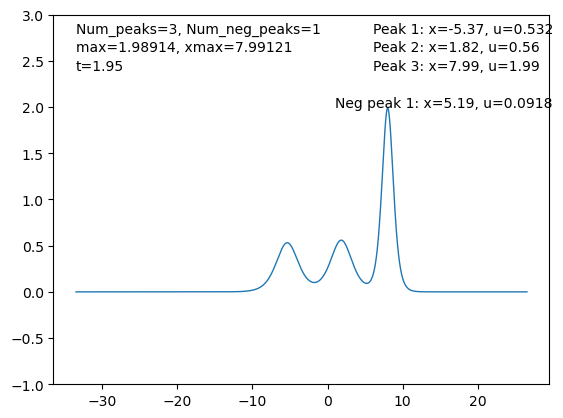

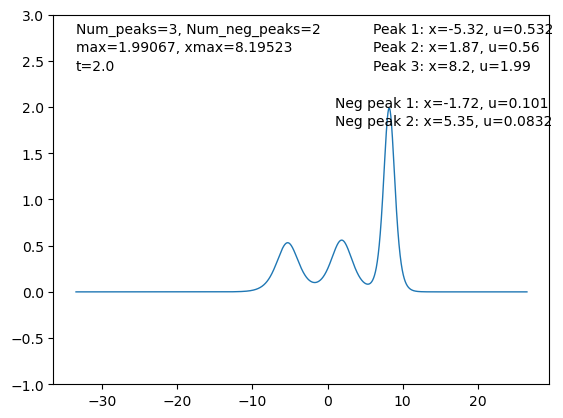

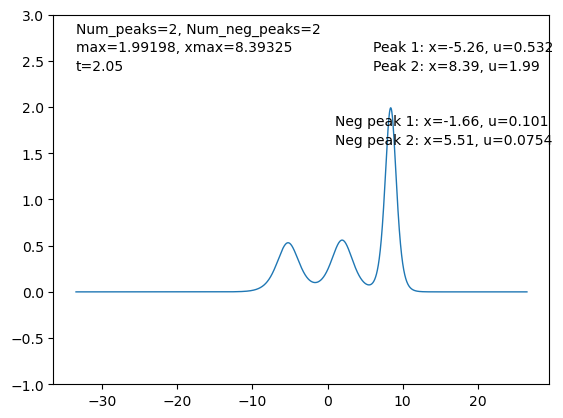

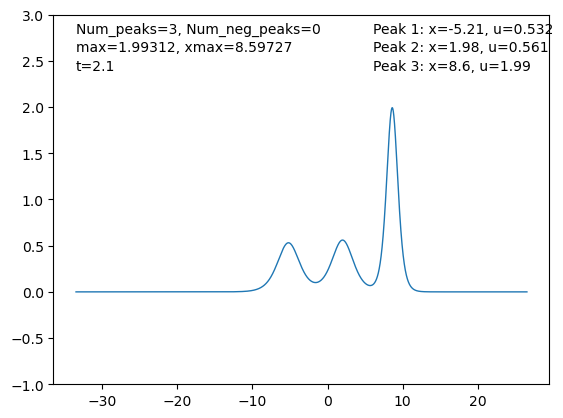

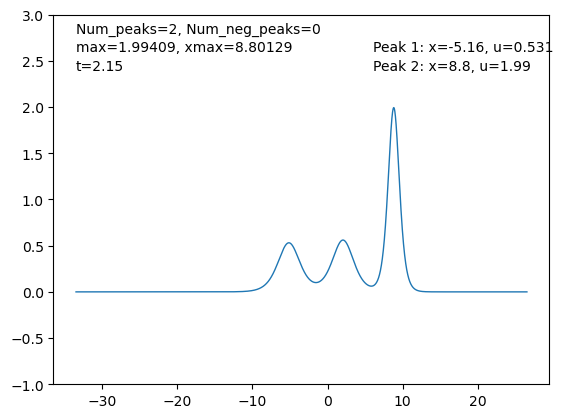

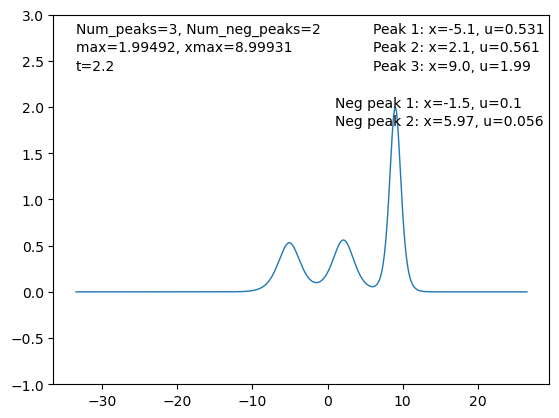

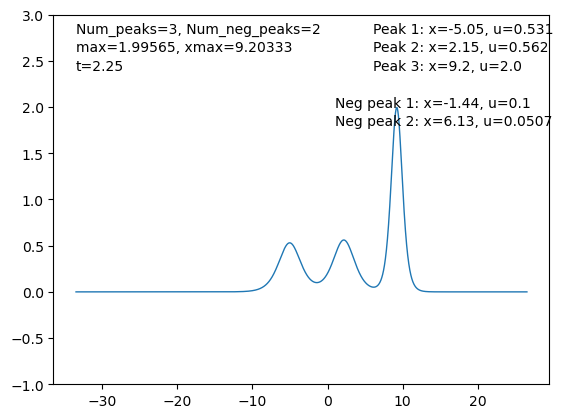

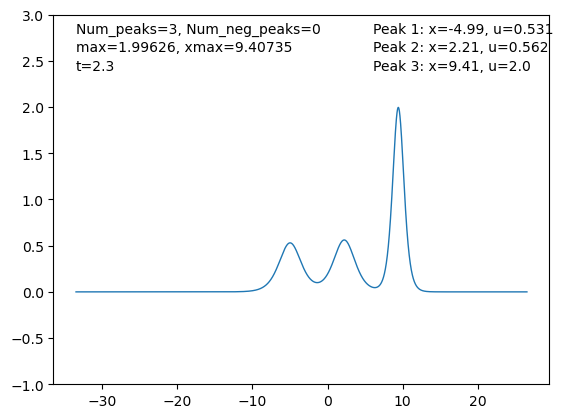

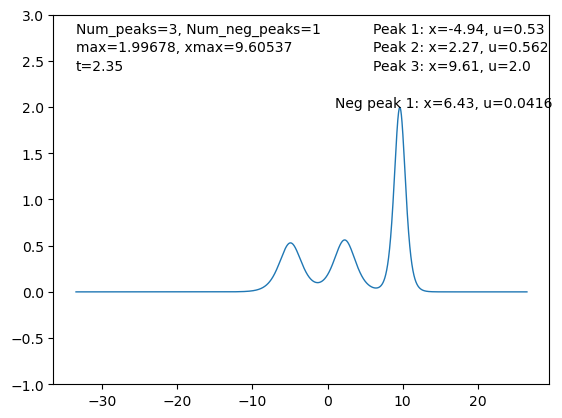

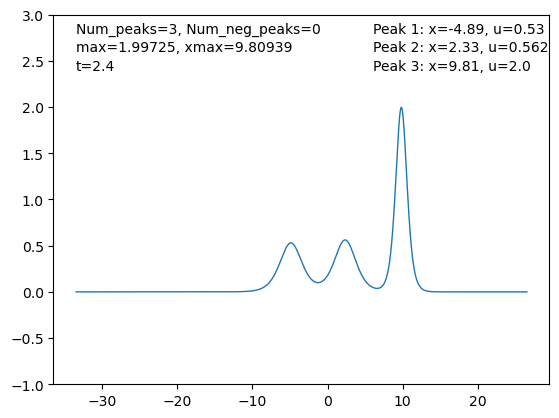

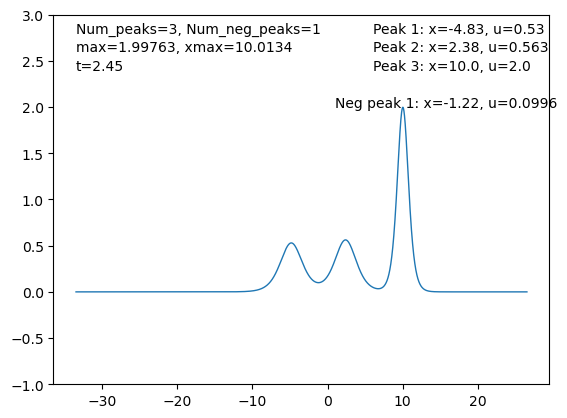

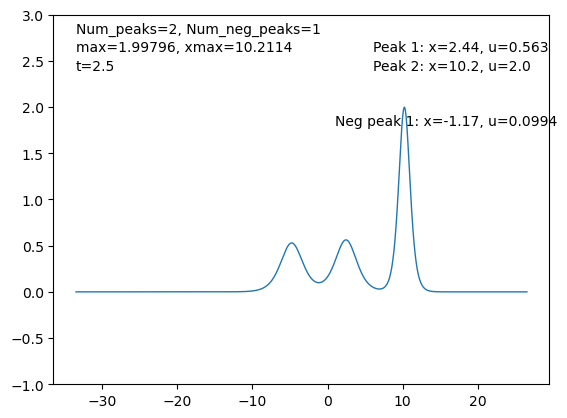

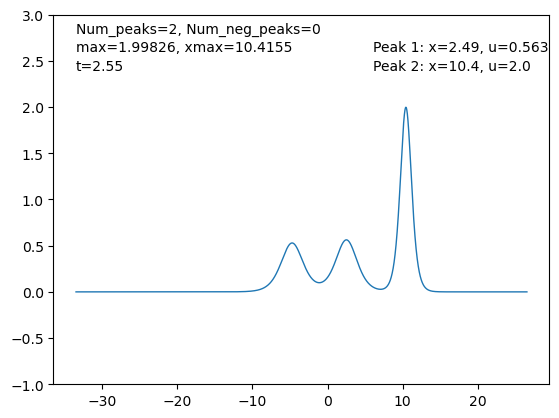

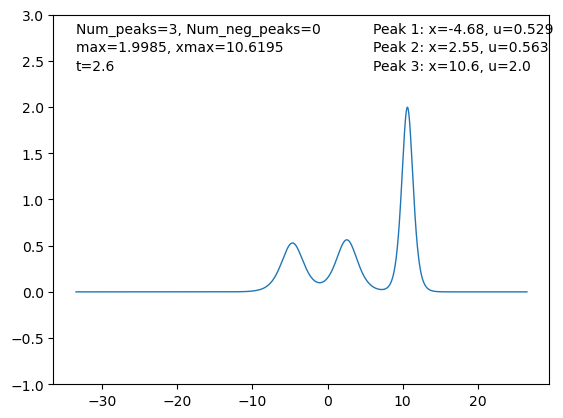

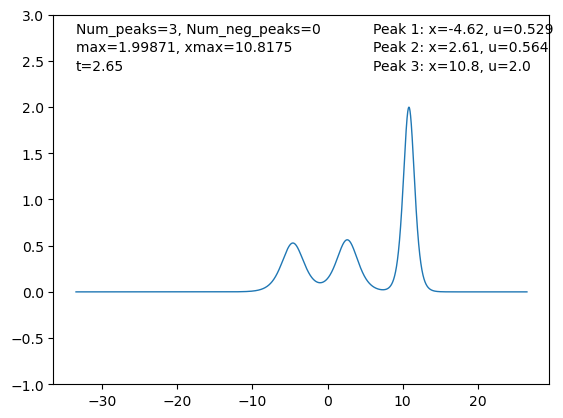

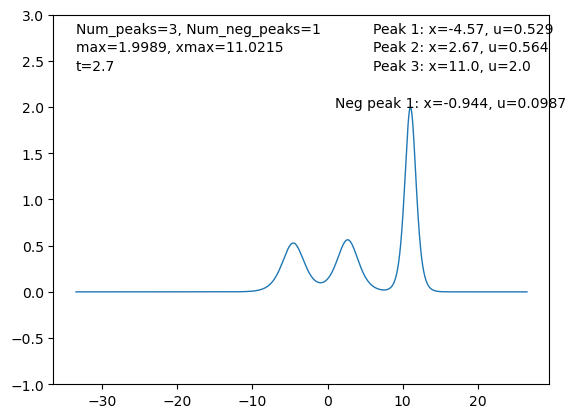

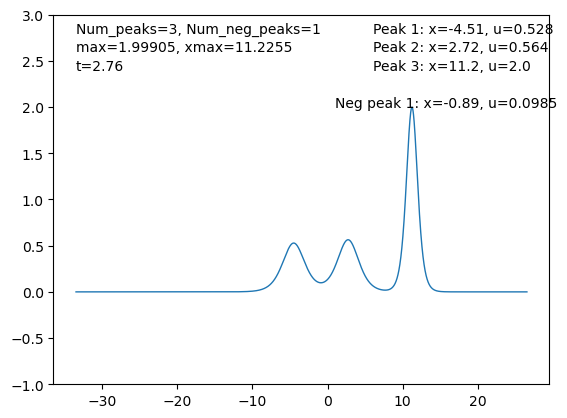

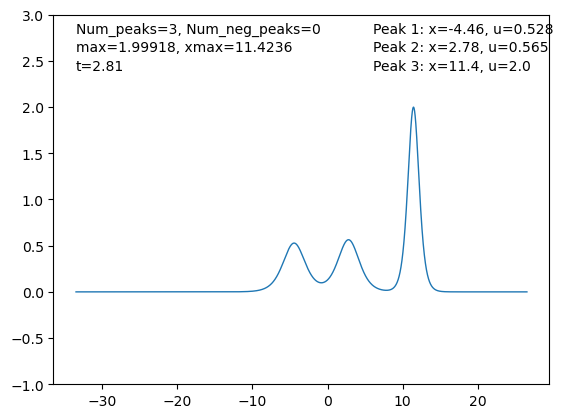

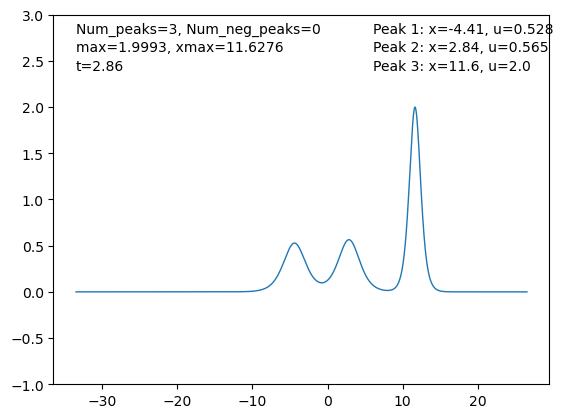

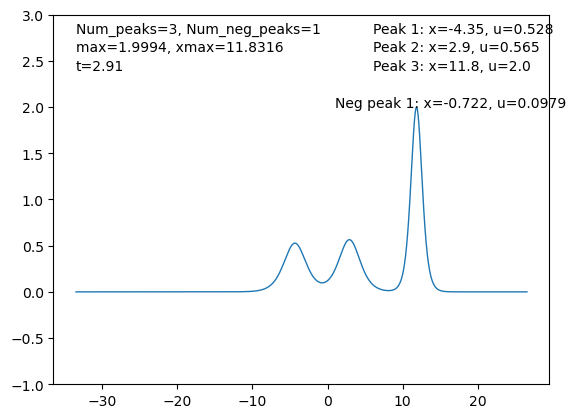

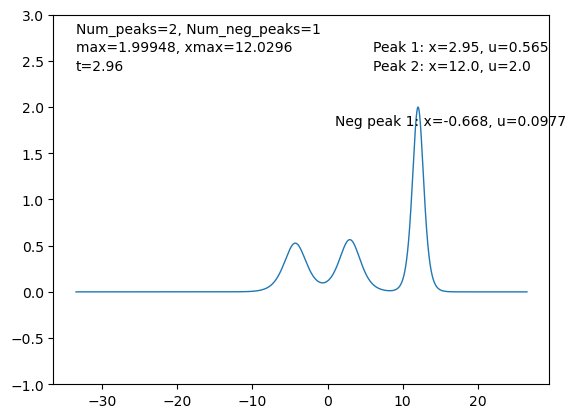

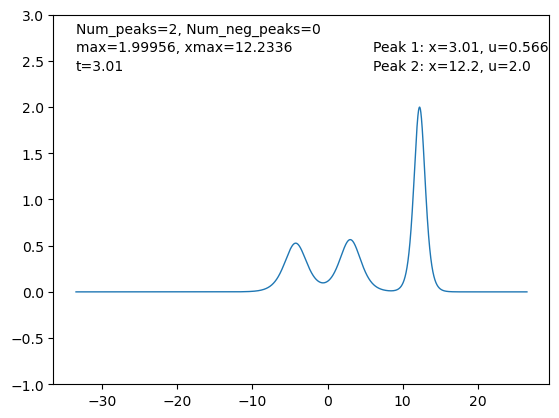

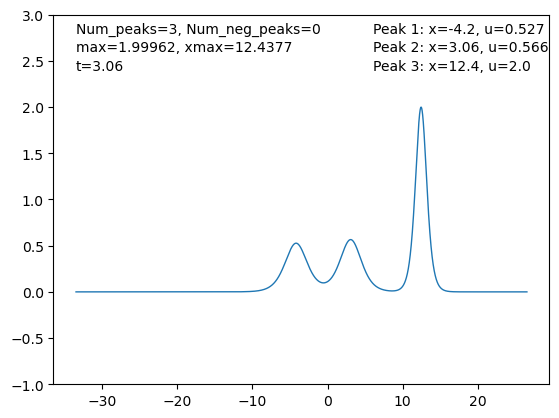

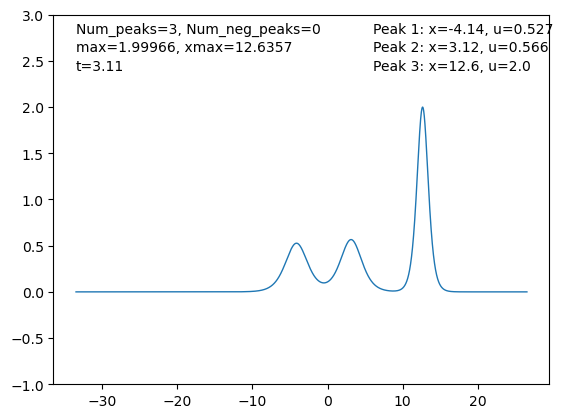

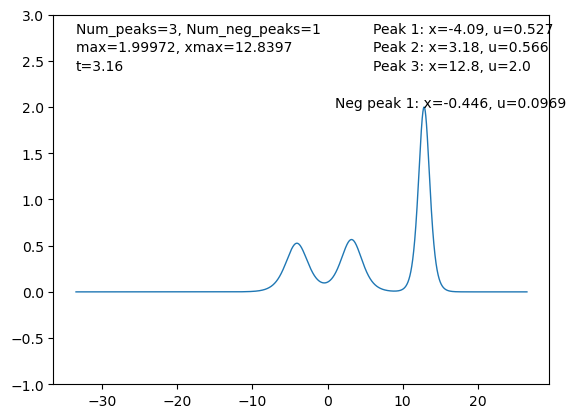

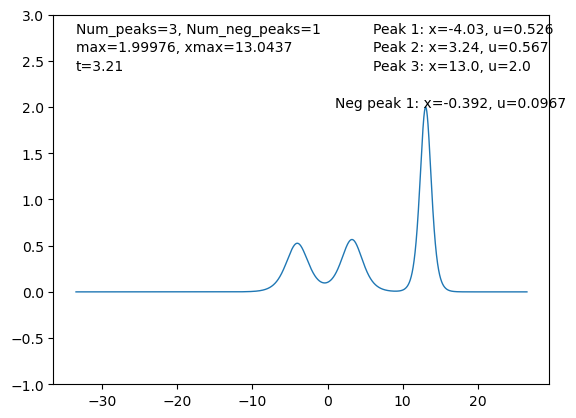

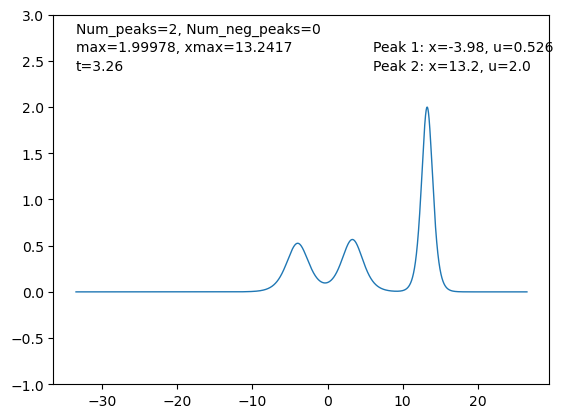

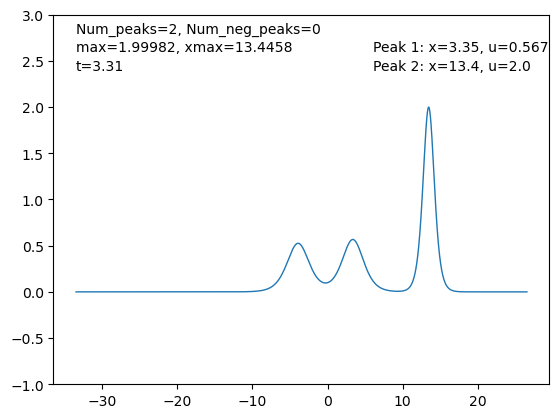

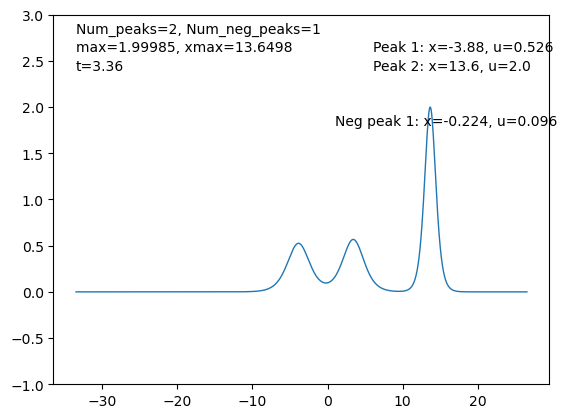

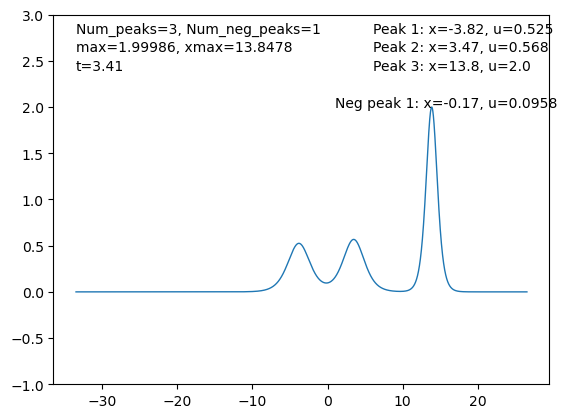

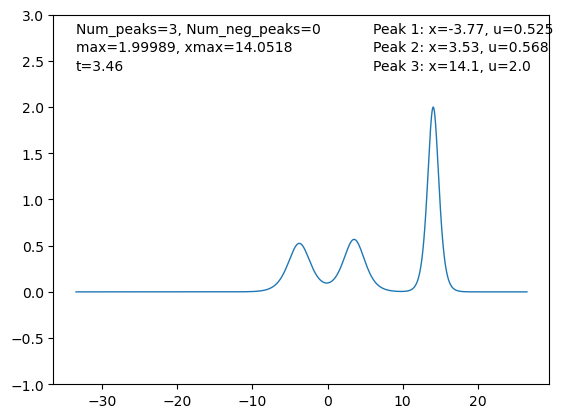

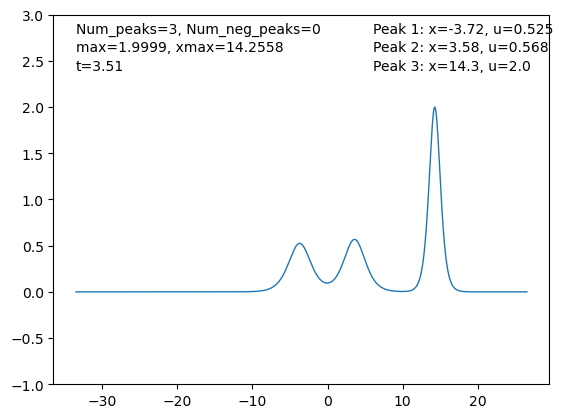

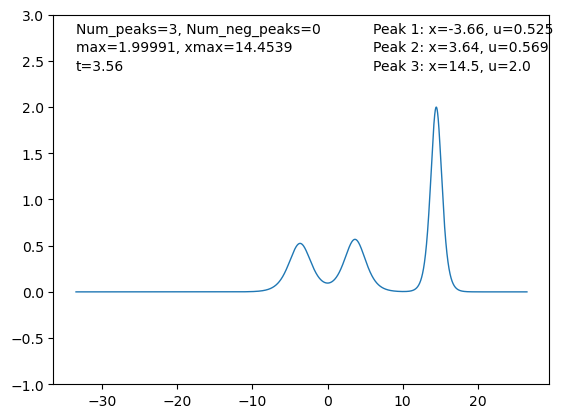

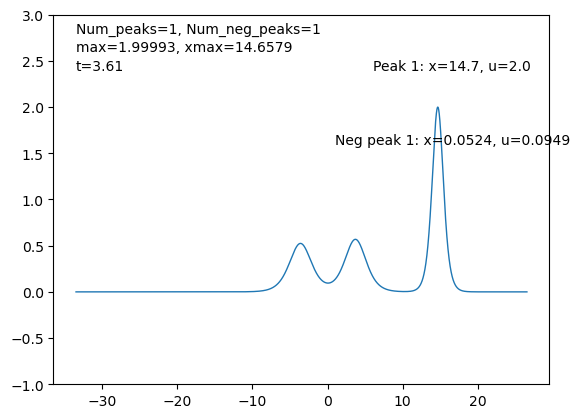

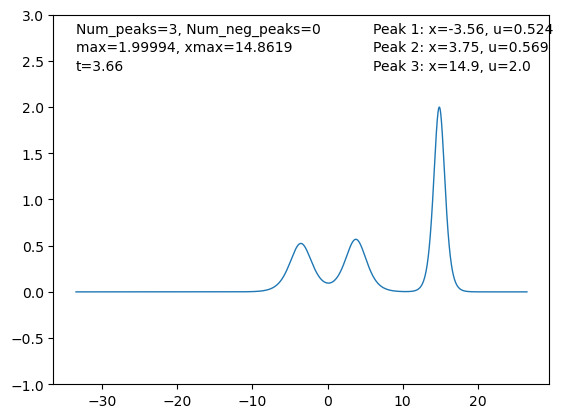

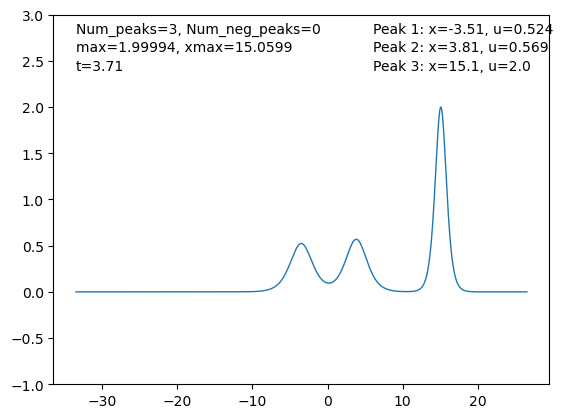

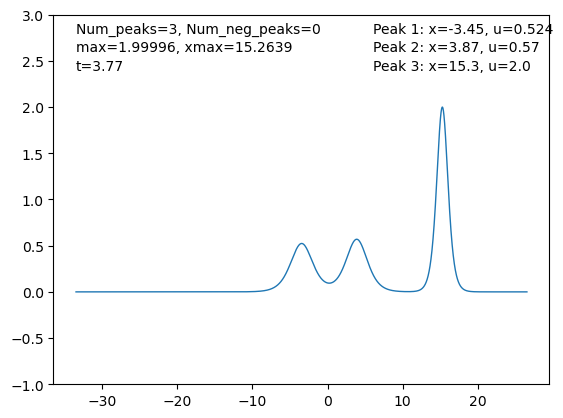

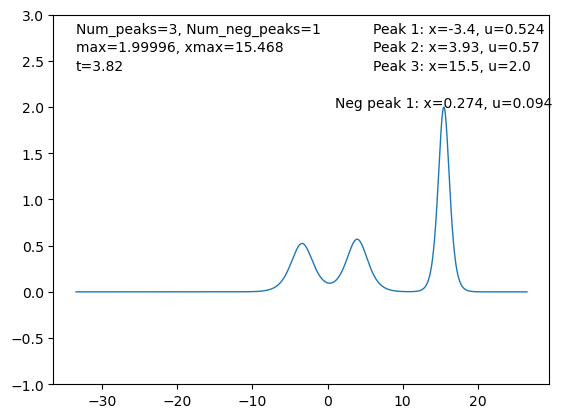

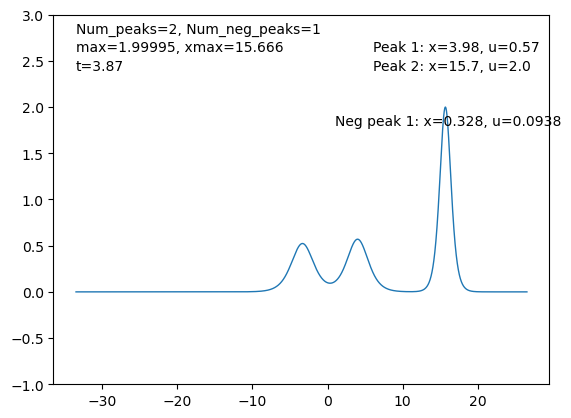

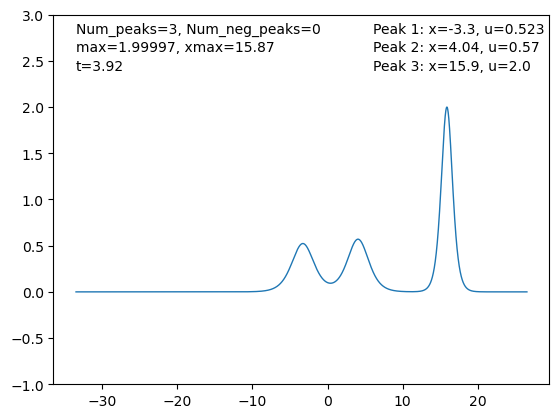

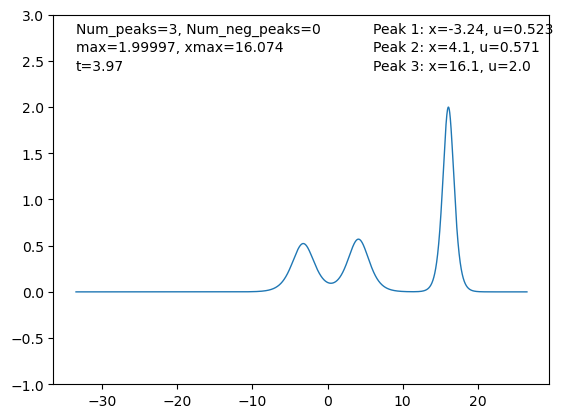

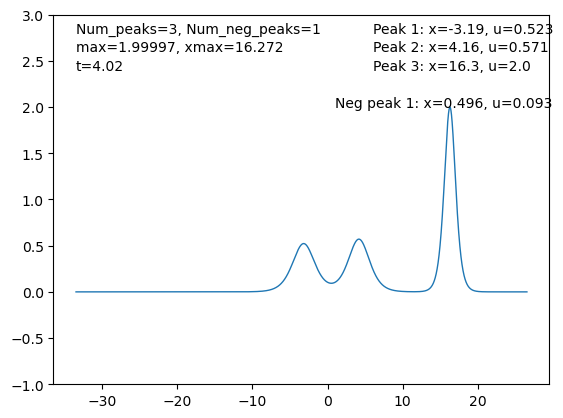

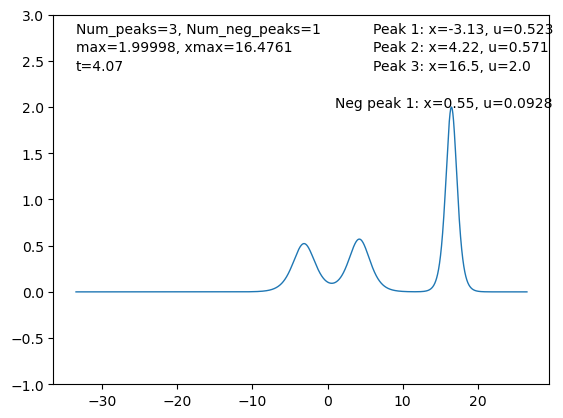

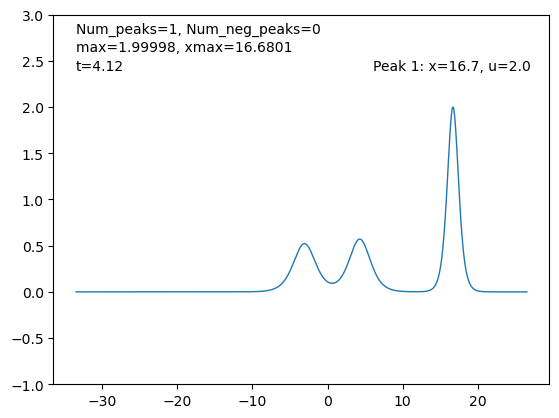

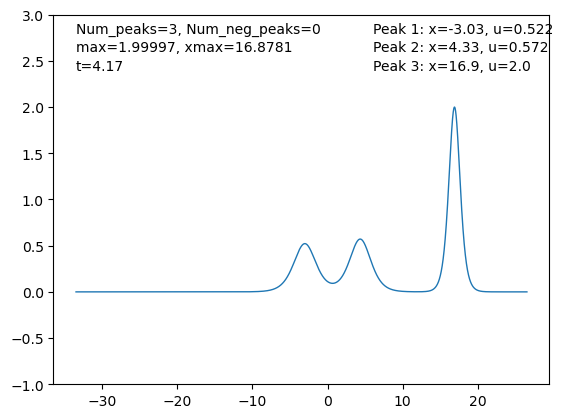

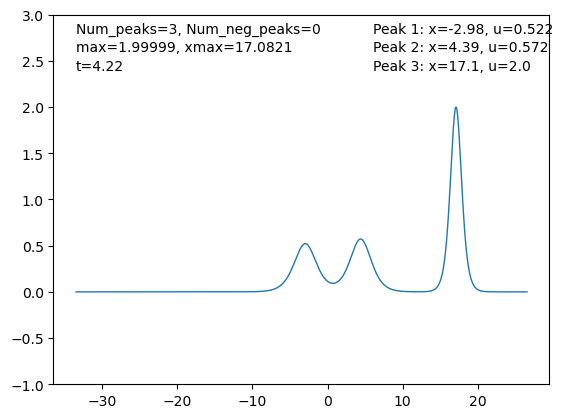

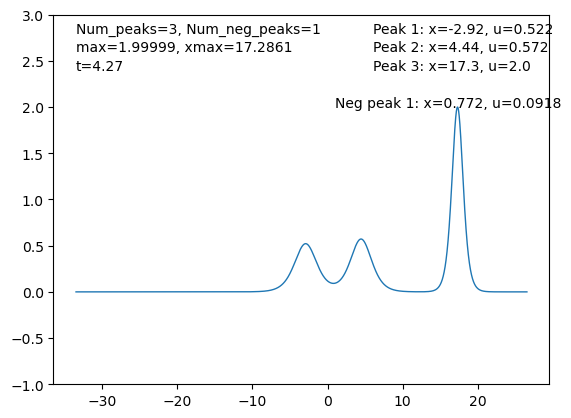

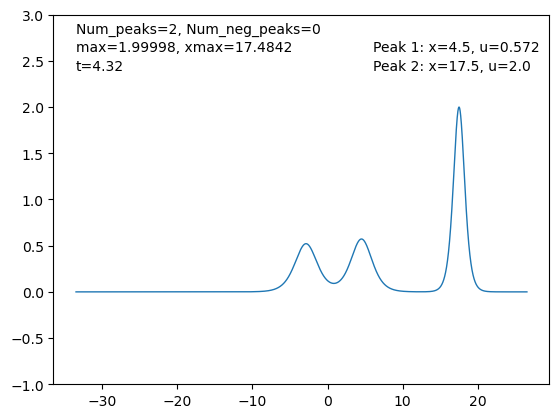

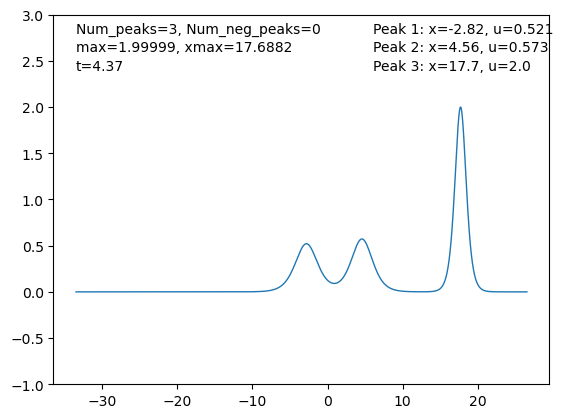

In [90]:
umaxarr = []

for (t, uarr) in zip(tarr, u):
    make_plot(xarr, uarr, t, show=1, linewidth=1)

In [10]:
kappa3**2 * 2

0.5